In [1]:
import oed_toolbox
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, '..')
import plotting_helpers

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100
palette = sns.color_palette()
# Seaborn theme:
sns.set_theme(style='darkgrid')

In [3]:
fig_save_dir = './figs/locallin'
if not os.path.isdir(fig_save_dir):
    os.mkdir(fig_save_dir)

Create linear model:

In [4]:
K_func = lambda d: -1*(d-1)**2  # jnp.atleast_2d(-1*(d-5)**2 + 20)
b_func = lambda d: 0.2*d**(1/2) + 2
def create_linear_model(K_func, b_func):
    def linear_model(theta, d):
        theta = jnp.atleast_1d(theta.squeeze())
        return K_func(d)*theta + b_func(d)
    return linear_model

In [5]:
prior_mean = jnp.array([1.0])
prior_cov = jnp.identity(1)
noise_cov = 0.1*jnp.identity(1)
model_func = create_linear_model(K_func, b_func)
model_func_dt = jax.jacfwd(model_func, argnums=0)
model = oed_toolbox.models.Model.from_jax_function(model_func)

# Posterior check:

In [6]:
minimizer = oed_toolbox.optim.gradient_descent_for_map()
approx_posterior = \
oed_toolbox.distributions.Posterior.laplace_approximation(model, minimizer, noise_cov, prior_mean, prior_cov)

In [7]:
noise_icov = jnp.linalg.inv(noise_cov)
prior_icov = jnp.linalg.inv(prior_cov)

def logposterior(theta, y, d):
    K = K_func(d)
    b = b_func(d)
    icov = K.T @ noise_icov @ K + prior_icov
    cov = jnp.linalg.inv(icov)
    mean = ((y-b).T @ noise_icov @ K + prior_mean.T @ prior_icov) @ cov
    return jax.scipy.stats.multivariate_normal.logpdf(theta, mean=mean, cov=cov)

true_posterior = \
{'logpdf': jax.vmap(logposterior, in_axes=(0,None,None)),
 'logpdf_dd': jax.vmap(jax.jacfwd(logposterior, argnums=2), in_axes=(0,None,None)), 
 'logpdf_dy': jax.vmap(jax.jacfwd(logposterior, argnums=1), in_axes=(0,None,None))}

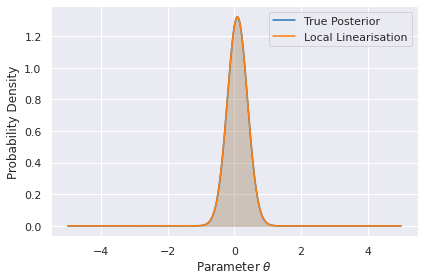

In [8]:
theta_plot = jnp.linspace(-5,5,1000).reshape(-1,1)
y = jnp.array([[2]])
d = jnp.array([[0]])
pdfs = {'True Posterior': jnp.exp(true_posterior['logpdf'](theta_plot, y, d)),
        'Local Linearisation': jnp.exp(approx_posterior.logpdf(theta_plot, y, d)['logpdf'])}
plotting_helpers.plot_distributions(pdfs, theta_plot, 'Parameter $\\theta$')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'll_post.svg'))

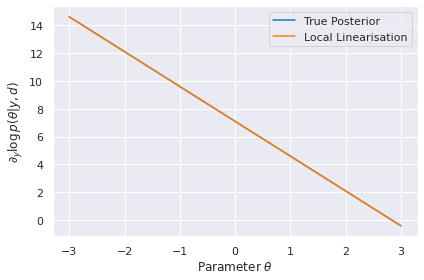

In [9]:
theta_plot = jnp.linspace(-3,3,1000).reshape(-1,1)
y = jnp.array([[0.8]])
d = jnp.array([[1.5]])
pdfs_dy = {'True Posterior': true_posterior['logpdf_dy'](theta_plot, y, d),
           'Local Linearisation': approx_posterior.logpdf(theta_plot, y, d, return_dy=True)['logpdf_dy']}
fig, ax = plt.subplots()
for i, (key, grad) in enumerate(pdfs_dy.items()):
    sns.lineplot(x=theta_plot.squeeze(), y=grad.squeeze(), color=palette[i], label=key)
plotting_helpers.clean_up_plot(fig)
ax.set_xlabel("Parameter $\\theta$")
ax.set_ylabel('$\partial_y \log{p(\\theta|y,d)}$')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'll_post_dy.svg'))

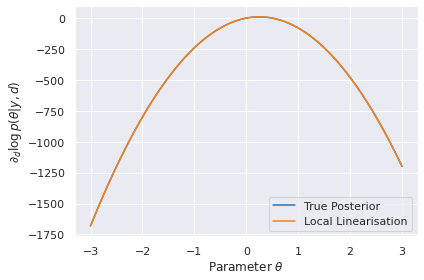

In [10]:
theta_plot = jnp.linspace(-3,3,1000).reshape(-1,1)
y = jnp.array([[0.4]])
d = jnp.array([[3.]])
pdfs_dd = {'True Posterior': true_posterior['logpdf_dd'](theta_plot, y, d),
           'Local Linearisation': approx_posterior.logpdf(theta_plot, y, d, return_dd=True)['logpdf_dd']}
fig, ax = plt.subplots()
for i, (key, grad) in enumerate(pdfs_dd.items()):
    sns.lineplot(x=theta_plot.squeeze(), y=grad.squeeze(), color=palette[i], label=key)
plotting_helpers.clean_up_plot(fig)
ax.set_xlabel("Parameter $\\theta$")
ax.set_ylabel('$\partial_d \log{p(\\theta|y,d)}$')
plt.tight_layout()
plt.savefig(os.path.join(fig_save_dir, 'll_post_dd.svg'))